In [1]:
chrome_driver = './chromedriver' # 파일 확장자 이름 미표기
URL = 'https://play.google.com/store/apps/details?id=com.lgeha.nuts&hl=ko&gl=US'

In [2]:
import requests
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import time
from time import sleep
import random
from tqdm.auto import tqdm, trange
import pandas as pd

In [3]:
def scroll(modal, k):
    try:        
        # 스크롤 높이 받아오기
        cnt = 0
        last_height = driver.execute_script("return arguments[0].scrollHeight", modal)
        while True:
            pause_time = random.uniform(0.5, 0.8)
            # 최하단까지 스크롤
            driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight);", modal)
            # 페이지 로딩 대기
            time.sleep(pause_time)
            # 무한 스크롤 동작을 위해 살짝 위로 스크롤
            driver.execute_script("arguments[0].scrollTo(0, arguments[0].scrollHeight-50);", modal)
            time.sleep(pause_time)
            # 스크롤 높이 새롭게 받아오기
            new_height = driver.execute_script("return arguments[0].scrollHeight", modal)
            if cnt == k:
                break
            cnt += 1
            if cnt%5==0:
                print(cnt)
            try:
                # '더보기' 버튼 있을 경우 클릭
                all_review_button = driver.find_element_by_xpath('/html/body/div[1]/div[4]/c-wiz/div/div[2]/div/div/main/div/div[1]/div[2]/div[2]/div/span/span').click()
            except:
                # 스크롤 완료 경우
                if new_height == last_height:
                    print("스크롤 완료")
                    break
                last_height = new_height
                
    except Exception as e:
        print("에러 발생: ", e)

In [5]:
# 크롬 드라이버 세팅
driver = webdriver.Chrome(chrome_driver)
# 페이지 열기
driver.get(URL)
# 페이지 로딩 대기
wait = WebDriverWait(driver, 5)

# '리뷰 모두 보기' 버튼 렌더링 확인
all_review_button_xpath = '/html/body/c-wiz[2]/div/div/div[1]/div[2]/div/div[1]/c-wiz[4]/section/div/div/div[5]/div/div/button/span'
button_loading_wait = wait.until(EC.element_to_be_clickable((By.XPATH, all_review_button_xpath)))
# '리뷰 모두 보기' 버튼 클릭
driver.find_element_by_xpath(all_review_button_xpath).click()

# '리뷰 모두 보기' 페이지 렌더링 대기
# all_review_page_xpath = '/html/body/c-wiz[2]/div/div/div[1]/div[2]/div/div[1]/c-wiz[3]/section/div/div/div[5]/div/div/button/span'
# page_loading_wait = wait.until(EC.element_to_be_clickable((By.XPATH, all_review_page_xpath)))

# 페이지 무한 스크롤 다운
modal = WebDriverWait(driver, 2).until(EC.element_to_be_clickable((By.XPATH, "//div[@class='fysCi']")))
k = int(input("스크롤을 어디서부터 몇 번 내릴까요?(120+80n)개: "))
scroll(modal, k)

C:\Users\eunah.lee\AppData\Local\Temp/ipykernel_19100/4063221215.py:2: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chrome_driver)
C:\Users\eunah.lee\AppData\Local\Temp/ipykernel_19100/4063221215.py:12: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  driver.find_element_by_xpath(all_review_button_xpath).click()


스크롤을 어디서부터 몇 번 내릴까요?(120+80n)개: 65


C:\Users\eunah.lee\AppData\Local\Temp/ipykernel_19100/1820617884.py:24: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  all_review_button = driver.find_element_by_xpath('/html/body/div[1]/div[4]/c-wiz/div/div[2]/div/div/main/div/div[1]/div[2]/div[2]/div/span/span').click()


5
10
15
20
25
30
35
40
45
50
55
60
65


In [6]:
# html parsing하기
html_source = driver.page_source
soup_source = BeautifulSoup(html_source, 'html.parser')

# 리뷰 데이터 클래스 접근
review_source = soup_source.find_all(class_ = 'RHo1pe')
# 리뷰 데이터 저장용 배열
dataset = []
# 데이터 넘버링을 위한 변수
review_num = 0 
# 리뷰 1개씩 접근해 정보 추출
for review in tqdm(review_source):
    review_num+=1
    # 리뷰 등록일 데이터 추출
    date_full = review.find_all(class_ = 'bp9Aid')[0].text
    date_year = date_full[0:4] # 연도 데이터 추출
    # 해당 단어가 등장한 인덱스 추출
    year_index = date_full.find('년')
    month_index = date_full.find('월')
    day_index = date_full.find('일')
    
    date_month = str(int(date_full[year_index+1:month_index])) # 월(Month) 데이터 추출
    # 월 정보가 1자리의 경우 앞에 0 붙이기(e.g., 1월 -> 01월)
    if len(date_month) == 1:
        date_month = '0' + date_month
    
    date_day = str(int(date_full[month_index+1:day_index])) # 일(Day) 데이터 추출 
    # 일 정보가 1자리의 경우 앞에 0 붙여줌(e.g., 7일 -> 07일)
    if len(date_day) == 1:
        date_day = '0' + date_day
    
    # 리뷰 등록일 full version은 최종적으로 yyyymmdd 형태로 저장
    date_full = date_year + date_month + date_day
    user_name = review.find_all(class_ = 'X5PpBb')[0].text # 닉네임 데이터 추출
    rating = review.find_all(class_ = "iXRFPc")[0]['aria-label'][10] # 평점 데이터 추출
    content = review.find_all(class_ = 'h3YV2d')[0].text # 리뷰 데이터 추출

    data = {
        "id": review_num, 
        "date": date_full,
        "dateYear": date_year,
        "dateMonth": date_month,
        "dateDay": date_day,
        "rating": rating,
        "userName": user_name,
        "content": content
    }
    dataset.append(data)

  0%|          | 0/5320 [00:00<?, ?it/s]

In [8]:
review_df = pd.DataFrame(dataset)
review_df.to_csv("./crawling_data/gps_thinq_original_65.csv", encoding='utf-8 sig')
review_df

,id,date,dateYear,dateMonth,dateDay,rating,userName,content
0,1,20210708,2021,07,08,3,Sangik Cho,"최근 구입한 물걸래 로봇청소기는 잘 연결되지만, 오래된 유준상 로봇청소기는 연결되지..."
1,2,20200828,2020,08,28,5,김인성,안녕하세요? lw2217ivsm 창문형 에어컨을 직구해서 한국에서 쓰고 있는데 한국...
2,3,20220713,2022,07,13,2,D Jay,한달쯤전부터 앱이 홈화면에서 새로고침(?)을 안함. 분명 에어컨을 켜고 온도조절을 ...
3,4,20220723,2022,07,23,1,BH C,UP가전 기능 되지도 않고 오류 투성인데 미리 홍보부터 한것같응. 공기청정기 사고 ...
4,5,20220716,2022,07,16,1,정다니엘,정수기 소리설정 끄기가 안돼요.. '네트워크 불안정' 오류뜨는데.. 와이파이 멀쩡히...
...,...,...,...,...,...,...,...,...
5315,5316,20190329,2019,03,29,5,Google 사용자,아... 정말 발전된 세상에 사는구나 싶네요^^
5316,5317,20200212,2020,02,12,5,Google 사용자,편하네요 잘쓰고있습니다
5317,5318,20201117,2020,11,17,5,박준일,신세계를 열어주네요 버튼하나로 모든 집안일을..
5318,5319,20201208,2020,12,08,4,DTC JSC.,"베트남에서 엘지 퓨리케어 와 세탁기, 티비를 사용중 입니다만 씽크큐가 구글 홈에 연..."


In [27]:
review_df['content']

0       최근 구입한 물걸래 로봇청소기는 잘 연결되지만, 오래된 유준상 로봇청소기는 연결되지...
1       안녕하세요? lw2217ivsm 창문형 에어컨을 직구해서 한국에서 쓰고 있는데 한국...
2       원격제어 정보에 동의한적 없음. 이게 개인정보 수집용 앱인지요?. 기기내에서 설치된...
3       몇년전부터 지속적으로 에어컨에 와이파이 연결 및 thinq 앱 연결이 자주 끊어져서...
4       시스템에어컨 1시간 뒤에 꺼지게 '끄기' 예약을 설정했는데 꺼지기는 커녕 풀로 새벽...
                              ...                        
4755                             청정기의 필터 상태를 확인할 수 있어 좋아요
4756                                등록한 제품의 순서변경은 불가능한가요?
4757                                           되게 편리한앱입니다
4758                                         좋아요 잘사용하고있어요
4759                               원격조정과 스마트케어를해주니아주 굳!!♥
Name: content, Length: 4760, dtype: object

In [28]:
# 문자 빼고 지움(정규표현식)
# 문장 자르기
import kss
import re

UNKNOWN_WORD = "...하"
def OnlyWords(s):
    result = re.sub('[^ A-Za-z가-힣]', '', s)
    return result

review_df['content_n']=review_df['content'].apply(\
        lambda x: kss.split_sentences(OnlyWords(x)) if UNKNOWN_WORD not in x else kss.split_sentences(OnlyWords(x).replace(UNKNOWN_WORD,"..")))

[Korean Sentence Splitter]: Initializing Pynori...


In [30]:
review_df.to_csv("./csv_file/sentence_review_loop60.csv", encoding='utf-8 sig')

In [37]:
review_df

,id,date,dateYear,dateMonth,dateDay,rating,userName,content,content_n
0,1,20210708,2021,07,08,3,Sangik Cho,"최근 구입한 물걸래 로봇청소기는 잘 연결되지만, 오래된 유준상 로봇청소기는 연결되지...",[최근 구입한 물걸래 로봇청소기는 잘 연결되지만 오래된 유준상 로봇청소기는 연결되지...
1,2,20200828,2020,08,28,5,김인성,안녕하세요? lw2217ivsm 창문형 에어컨을 직구해서 한국에서 쓰고 있는데 한국...,"[안녕하세요, lwivsm 창문형 에어컨을 직구해서 한국에서 쓰고 있는데 한국 구글..."
2,3,20211220,2021,12,20,1,M.Saint Kim,원격제어 정보에 동의한적 없음. 이게 개인정보 수집용 앱인지요?. 기기내에서 설치된...,[원격제어 정보에 동의한적 없음 이게 개인정보 수집용 앱인지요 기기내에서 설치된건 ...
3,4,20220618,2022,06,18,1,박한길,몇년전부터 지속적으로 에어컨에 와이파이 연결 및 thinq 앱 연결이 자주 끊어져서...,[몇년전부터 지속적으로 에어컨에 와이파이 연결 및 thinq 앱 연결이 자주 끊어져...
4,5,20220603,2022,06,03,2,공공,시스템에어컨 1시간 뒤에 꺼지게 '끄기' 예약을 설정했는데 꺼지기는 커녕 풀로 새벽...,[시스템에어컨 시간 뒤에 꺼지게 끄기 예약을 설정했는데 꺼지기는 커녕 풀로 새벽내내...
...,...,...,...,...,...,...,...,...,...
4755,4756,20210128,2021,01,28,5,이상근,청정기의 필터 상태를 확인할 수 있어 좋아요,[청정기의 필터 상태를 확인할 수 있어 좋아요]
4756,4757,20181128,2018,11,28,3,Google 사용자,등록한 제품의 순서변경은 불가능한가요?,[등록한 제품의 순서변경은 불가능한가요]
4757,4758,20190907,2019,09,07,5,Google 사용자,되게 편리한앱입니다,[되게 편리한앱입니다]
4758,4759,20200621,2020,06,21,5,이경호,좋아요 잘사용하고있어요,"[좋아요, 잘사용하고있어요]"


In [31]:
# 맞춤법 검사 
from hanspell import spell_checker

def spell_checking(sent_list):
    sent_spell=[]
    for sentence in sent_list:
        sent_spell.append(spell_checker.check(sentence).checked)
    return(sent_spell)

review_df['cotent_n_spell']=review_df['content_n'].apply(lambda x: spell_checking(x))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [32]:
review_df['content_n']=review_df['cotent_n_spell']

KeyError: 'cotent_n_spell'

In [56]:
from konlpy.tag import Okt  
okt=Okt() 
# 명사, 형용사, 동사
def n_a_v_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Verb')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens

# 명사, 형용사
def n_a_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        pos_result=okt.pos(sentence, stem=True)
        filtered_result=[pair[0] for pair in pos_result if (pair[1]=='Alpha')or(pair[1]=='Noun')or(pair[1]=='Adjective') or(pair[1]=='Adverb')]
        sent_tokens.append(filtered_result)
    return sent_tokens
        
# 명사만
def noun_selection(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        sent_tokens.append(okt.nouns(sentence))
    return(sent_tokens)

review_df['content_n']=review_df['content_n'].apply(lambda x: noun_selection(x))

In [20]:
# review_df['content_n']=review_df['content_n'].apply(lambda x: n_a_v_selection(x))
# review_df['comment_n']=review_df['comment_n'].apply(lambda x: noun_selection(x))

In [45]:
# 불용어 처리
import json

with open('korean_stopword.json',encoding='utf8') as f:
    stopwords = json.load(f)

stopwords.extend(['안','수','거','왜','것','후','에서','고','이다','는','한','안녕','형','형님','건','안','요','거','피','질','번','용','군','영','스','좀','데','듯','넉','테','런','하다','하나요','되다','안되다','있다','없다'])

def rem_n_stopwords(sent_list):
    sent_stop=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if token not in stopwords:
                new_sent.append(token)
        sent_stop.append(new_sent)
    return(sent_stop)

review_df['content_n']=review_df['content_n'].apply(lambda x: rem_n_stopwords(x))

In [46]:
# 빈 리스트 제거
def remove_empty_list(sent_list):
    removed_list = []
    for sentence in sent_list:
        if sentence: # sentence가 빈 경우가 아니면
            removed_list.append(sentence)    
    return removed_list

review_df['content_n']=review_df['content_n'].apply(lambda x: remove_empty_list(x))

# review_df.to_csv('thinq_review_result.csv',index=False, encoding='utf-8-sig')

# 리뷰 전체를 한 리스트로 만들기
def one_word_list(sent_list):
    one_list=[]
    for sentence in sent_list:
        one_list.extend(sentence)
    return(one_list)

review_df['content_n']=review_df['content_n'].apply(lambda x: one_word_list(x))

In [47]:
# 단어 빈도 그래프
total_word=[]
for i in range(len(review_df)):
    total_word.extend(review_df.loc[i,'content_n'])

word_vc = pd.Series(total_word).value_counts()

In [51]:
pd.Series(total_word).to_list()

['최근',
 '구입',
 '물걸',
 '로봇청소기',
 '연결',
 '오래되다',
 '유준상',
 '로봇청소기',
 '연결',
 '앱',
 '전용',
 '앱',
 '신규',
 '앱',
 '계속',
 '연결',
 '진행',
 '중인',
 '상태',
 '진행',
 '더',
 '구형',
 '모델',
 '제대로',
 '작동',
 '안녕하다',
 'lwivsm',
 '창문',
 '에어컨',
 '직구',
 '한국',
 '한국',
 '구글플레이',
 '스토어',
 'lg',
 'thinq',
 '앱',
 '창문',
 '에어컨',
 '항목',
 '이동형',
 '에어컨',
 '항목',
 '선택',
 '진행',
 '와이파이',
 '연결',
 '지원',
 '제품',
 '사용',
 '가능하다',
 '방법',
 '알다',
 '주시',
 '친철',
 '자세하다',
 '설명',
 '감사',
 '덕분',
 '설정',
 '격',
 '제어',
 '정보',
 '동의',
 '한적',
 '개인정보',
 '수집',
 '앱',
 '인지',
 '기내',
 '설치',
 '확인',
 '악성',
 '앱',
 '수정',
 '일대일',
 '상담',
 '출고',
 'AS',
 '격',
 '제어',
 '없이',
 '수명',
 '다',
 '문제',
 '없이',
 '사용',
 '좋다',
 '기지',
 '기기',
 '대한',
 '지문',
 '다',
 '보이',
 '달라',
 '심보',
 '앱',
 '설치',
 '순간',
 '폭탄',
 '수도',
 '블루투스',
 '기간',
 '연결하다',
 '위치',
 '정보',
 '필요하다',
 '위치',
 '정보',
 '거부',
 '일부',
 '앱',
 '작동',
 '문제',
 '명시',
 '앱',
 '유료',
 '결제',
 '금액',
 '러시',
 '폰',
 '사업',
 'U',
 '도',
 '가요',
 '블루투스',
 '달리',
 '기기',
 '식',
 '제어',
 '가요',
 '년전',
 '지속',
 '에어컨',
 '와이파이',
 '연결',
 'thinq',
 '앱',
 '연

In [52]:
# 맞춤법 검사 
from hanspell import spell_checker

def spell_checking(sent_list):
    sent_spell=[]
    for sentence in sent_list:
        sent_spell.append(spell_checker.check(sentence).checked)
    return(sent_spell)

tmp = spell_checking(pd.Series(total_word).to_list())
# review_df['cotent_n_spell']=review_df['content_n'].apply(lambda x: spell_checking(x))

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

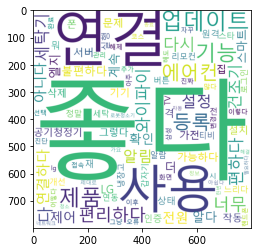

In [49]:
# 워드클라우드
from wordcloud import WordCloud
import matplotlib.pyplot as plt

word_dict = word_vc.to_dict()
delete_word = ['앱','어플','엘지']
for word in delete_word:
    del word_dict[word]

wc = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf', 
               width=400, height=400,scale=2,
               max_font_size=250, max_words=100,
               background_color='white')
gen = wc.generate_from_frequencies(word_dict)
plt.figure()
plt.imshow(gen)

<AxesSubplot:>

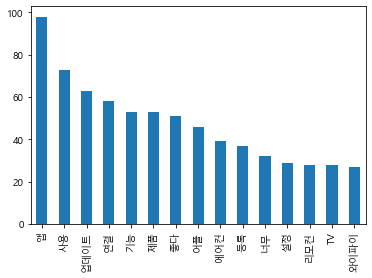

In [38]:
# 단어 빈도 그래프
# 한글 폰트 사용
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

pd.Series(total_word).value_counts().head(15).plot(kind='bar')

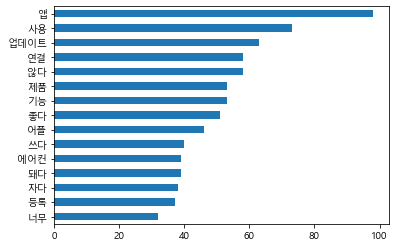

In [31]:
pd.Series(total_word).value_counts().head(15).plot(kind='barh').invert_yaxis()